In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm

In [2]:
L = 1 
Ts = 0.05
K_rotation = L/Ts
K_translation = 1/Ts

W = np.identity(6)
V_c = np.identity(5)
V_nc = np.identity(2)

# Filtre de Kalman

### Fonctions d'évolution

In [3]:
A = np.array([[1, 0, 0, Ts, 0, 0],
              [0, 1, 0, 0, Ts, 0],
              [0, 0, 1, 0, 0, Ts],
              [0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 1]])

In [4]:
A_sys = np.array([[0, 0, 0, 1, 0, 0],
                  [0, 0, 0, 0, 1, 0],
                  [0, 0, 0, 0, 0, 1],
                  [0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0]])

if (expm(A_sys*Ts)==A).any():
    print("La discrétisation exacte est égale à A càd que l'on ne peut pas faire mieux")
else:
    print("Wrong")

La discrétisation exacte est égale à A càd que l'on ne peut pas faire mieux


In [ ]:
def g_c(z):
    theta = z[2]
    s_c=[z[0], # x
        z[1], # y
        z[2], # theta
        z[3]*np.cos(theta) + z[4]*np.sin(theta), # x_dot*cos(theta) + y_dot*sin(theta)
        L*z[5]] # L*theta_dot
    return np.array(s_c)

def g_nc(z):
    theta = z[2]
    s_nc=[theta,
          z[3]*np.cos(theta) + z[4]*np.sin(theta), # x_dot*cos(theta) + y_dot*sin(theta)
          L*z[5]] # L*theta_dot
    return np.array(s_nc)

def grad_g_c(z):
    theta = z[2]
    x_dot, y_dot = z[3], z[4]
    grad = [[1, 0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0],
            [0, 0, -x_dot*np.sin(theta) + y_dot*np.cos(theta), np.cos(theta), np.sin(theta), 0],
            [0, 0, 0, 0, 0, L]]
    return np.array(grad)

def grad_g_nc(z):
    theta = z[2]
    x_dot, y_dot = z[3], z[4]
    grad = [[0,0,1,0,0,0],
            [0, 0, -x_dot*np.sin(theta) + y_dot*np.cos(theta), np.cos(theta), np.sin(theta), 0],
            [0, 0, 0, 0, 0, L]]
    return np.array(grad)

### Construction du vecteur observé

In [ ]:
def constructing_s(V_left_measure, V_right_measure, camera_working=False, 
                   x_measured=0, y_measured=0, theta_measured=0):
    s_nc = np.array([theta_measured,
                     (V_left_measure + V_right_measure)/2,
                     (V_left_measure - V_right_measure)/2])
    if camera_working:
        s_c = np.append(np.array([x_measured,y_measured]),
                        s_nc)
        return s_c
    return s_nc

### Etape de filtrage

In [7]:
def filtering_step(z_k_k_1, sigma_k_k_1, V_left_measure, V_right_measure, 
                   camera_working=False, x_measured=0, y_measured=0, theta_measured=0):
    ### Computing the variables that are dependant on the state of the camera
    C_k = grad_g_c(z_k_k_1) if camera_working else grad_g_nc(z_k_k_1)
    V = V_c if camera_working else V_nc
    s_k = constructing_s(V_left_measure, V_right_measure, camera_working,
                          x_measured, y_measured, theta_measured)
    g_k = g_c(z_k_k_1) if camera_working else g_nc(z_k_k_1)

    ### The real filtering step that can be rewritten without any problem
    L_k_k = sigma_k_k_1@C_k.T@np.linalg.inv(C_k@sigma_k_k_1@C_k.T + V)
    sigma_k_k = sigma_k_k_1 - L_k_k@C_k@sigma_k_k_1
    z_k_k = z_k_k_1 + L_k_k@(s_k-g_k)

    return z_k_k, sigma_k_k

### Etape de Prédiction

In [8]:
def prediction_step(z_k_k, sigma_k_k):
    z_k_1_k = A@z_k_k
    sigma_k_1_k = A@sigma_k_k@A.T + W
    return z_k_1_k, sigma_k_1_k

### Génération d'un vecteur d'état

In [9]:
def generating_z_prediction(z_mean, z_cov_matrix):
    return np.random.multivariate_normal(z_mean, z_cov_matrix)

# Contrôleur

In [10]:


l = 5 # mm --- demi-côté du carré



def robot_close_waypoint(pos_estimate, xb, yb):
    """_summary_
    Return a boolean to say if the robot is in a square with (xb,yb) as center and 2*l as length size
    Args:
        pos_estimate (1D np array with 2 variables): x,y position of the robot in mm
        xb (float): x position of the waypoint
        yb (float): y position of the waypoint
    """
    ones = np.array([1,
                1,
                1,
                1])
    F = np.array([[1, 0],
              [-1,0],
              [0, 1],
              [0,-1]])
    pos_waypoint = np.array([xb,yb])

    if all(F@(pos_estimate - pos_waypoint) <= l*ones):
        return True
    else:
        return False

In [11]:
robot_close_waypoint(np.array([15-l,200-l]),15,200)

True

In [12]:
def get_vertices_waypoint(xb,yb):
    vertices = np.array([[xb+l,yb+l],
                         [xb-l,yb+l],
                         [xb-l,yb-l],
                         [xb+l,yb-l]])
    return vertices


def get_cone_angles_waypoint(pos_estimate,xb,yb, margin=0.05):
    """_summary_
    This function compute the range within which the robot should point before moving to the waypoint
    with a margin
    Args:
        pos_estimate (1D np array with 2 variables): x,y position of the robot in mm
        xb (float): x position of the waypoint
        yb (float): y position of the waypoint
        margin (float) : number between 0 and 1. (1-2*margin) corresponds to the coverage of the angle
        theta_max - theta_min
    """
    vertices = get_vertices_waypoint(xb,yb)
    angles = []
    for vertex in vertices:
        delta = vertex - pos_estimate
        angles.append(np.arctan2(delta[1],delta[0]))
    angles = np.array(angles)
    theta_max = np.max(angles)
    theta_min = np.min(angles)
    delta = theta_max - theta_min
    return theta_max - margin*delta, theta_min + margin*delta

def robot_align_waypoint(theta_estimate, theta_max, theta_min):
    if theta_estimate < theta_max and theta_estimate > theta_min:
        return True
    else:
        return False

In [13]:
xb = 200
yb = 200

pos_estimate = np.array([100,300])

theta_max, theta_min = get_cone_angles_waypoint(pos_estimate, xb,yb)
print((theta_max,theta_min))

robot_align_waypoint(-0.8, theta_max, theta_min)

(-0.7404356072476999, -0.8303607195471968)


True

In [14]:
test = np.array([-1,-2,-3,0])

if all(test <= 0):
    print("win")
else:
    print("lose")

win


In [15]:
def rotation_control(theta_estimate, xb, yb):
    theta_b = np.arctan2(yb,xb) # en rad
    u = K_rotation*(theta_b - theta_estimate)
    left_motor_target = u # en mm/s
    right_motor_target = -u # en mm/s
    return left_motor_target, right_motor_target

In [16]:
def translation_control(pos_estimate, xb, yb):
    x_estimate = pos_estimate[0] # mm
    y_estimate = pos_estimate[1] # mm
    theta_estimate = pos_estimate[2] # rad

    x1_b = np.cos(theta_estimate)*xb + np.sin(theta_estimate)*yb # mm
    x1_estimate = np.cos(theta_estimate)*x_estimate + np.sin(theta_estimate)*y_estimate # mm

    u = K_translation*(x1_b - x1_estimate)
    left_motor_target = u # en mm/s
    right_motor_target = u # en mm/s
    return left_motor_target, right_motor_target

### Example de code

In [17]:
z_mean = np.zeros(6)
z_cov_matrix = np.identity(6)

z_estimate = generating_z_prediction(z_mean, z_cov_matrix)
pos_estimate = z_estimate[:3]

Vg, Vd = rotation_control(pos_estimate[-1], 1,1)
print((Vg,Vd))

Vg, Vd = translation_control(pos_estimate, 1,1)
print((Vg,Vd))

(1.3525543127587936, -1.3525543127587936)
(18.047353306382607, 18.047353306382607)


In [18]:
### Example d'algo (non-testé) pour le contrôle de la rotation
xb = 200
yb = 200

pos_estimate = np.array([100,300,0])

theta_max, theta_min = get_cone_angles_waypoint(pos_estimate, xb,yb)

while not robot_align_waypoint(pos_estimate[-1], theta_max, theta_min):
    Vg, Vd = rotation_control(pos_estimate[-1], xb,yb)
    ### Kalman filter to update pos_estimate

ValueError: operands could not be broadcast together with shapes (2,) (3,) 

In [ ]:
### Example d'algo (non-testé) pour le contrôle de la translation
xb = 200
yb = 200

pos_estimate = np.array([100,300,-0.8])

while not robot_close_waypoint(pos_estimate[:2],15,200):
    Vg, Vd = translation_control(pos_estimate, xb,yb)
    ### Kalman filter to update pos_estimate

KeyboardInterrupt: 

# Simulation

In [19]:
z_mean_0 = np.array([10, #mm
                     10, #mm
                     np.pi/4,
                     5,
                     5,
                     0])

z_cov_0 = np.diag([3,3,np.pi/1000,0.1,0.1,np.pi/1000])

W = 100*np.diag([0.1,0.1,0.01,0.1,0.1,0.01])

V_c = 1000*np.diag([0.01,0.01,0.01,0.01,0.01])


N = 100 # Durée expérience

z=np.zeros((6,N))

z[:,0] = generating_z_prediction(z_mean_0, z_cov_0)

for i in range(1,N):
    w = generating_z_prediction(np.zeros(6),W)
    z[:,i] = A@z[:,i-1] + w

print(z[:,0])

[11.06897952 11.5458799   0.83234813  4.72080376  4.779495   -0.04183651]


In [20]:
z_0_minus_1 = z_mean_0

sigma_0_minus_1 = z_cov_0

z_filtered = []
sigma_filtered = []

z_predicted = [z_0_minus_1]
sigma_predicted = [sigma_0_minus_1]

for i in range(N):
    v = generating_z_prediction(np.zeros(5),V_c)
    s = g_c(z[:,i]) + v
    x_observed, y_observed, theta_observed = s[0], s[1], s[2]
    V_left_measured = s[3] + s[4]
    V_right_measured = s[3] - s[4]

    z_k_k, sigma_k_k= filtering_step(z_k_k_1 = z_predicted[-1], 
                                    sigma_k_k_1 = sigma_predicted[-1], 
                                    V_left_measure = V_left_measured, 
                                    V_right_measure = V_right_measured, 
                                    camera_working=False, 
                                    x_measured=x_observed, 
                                    y_measured=y_observed,
                                    theta_measured= theta_observed)
    
    z_filtered.append(z_k_k)
    sigma_filtered.append(sigma_k_k)

    z_k_1_k, sigma_k_1_k = prediction_step(z_k_k, sigma_k_k)
    z_predicted.append(z_k_1_k)
    sigma_predicted.append(sigma_k_1_k)

In [32]:
z_filtered_array = np.array(z_filtered)
z_filtered_array = z_filtered_array.T
#z_filtered_array[0,:]

In [ ]:
# for i in range(N):
#     z_filtered_array[:,i] = generating_z_prediction(z_filtered_array[:,i], sigma_filtered[i]) 

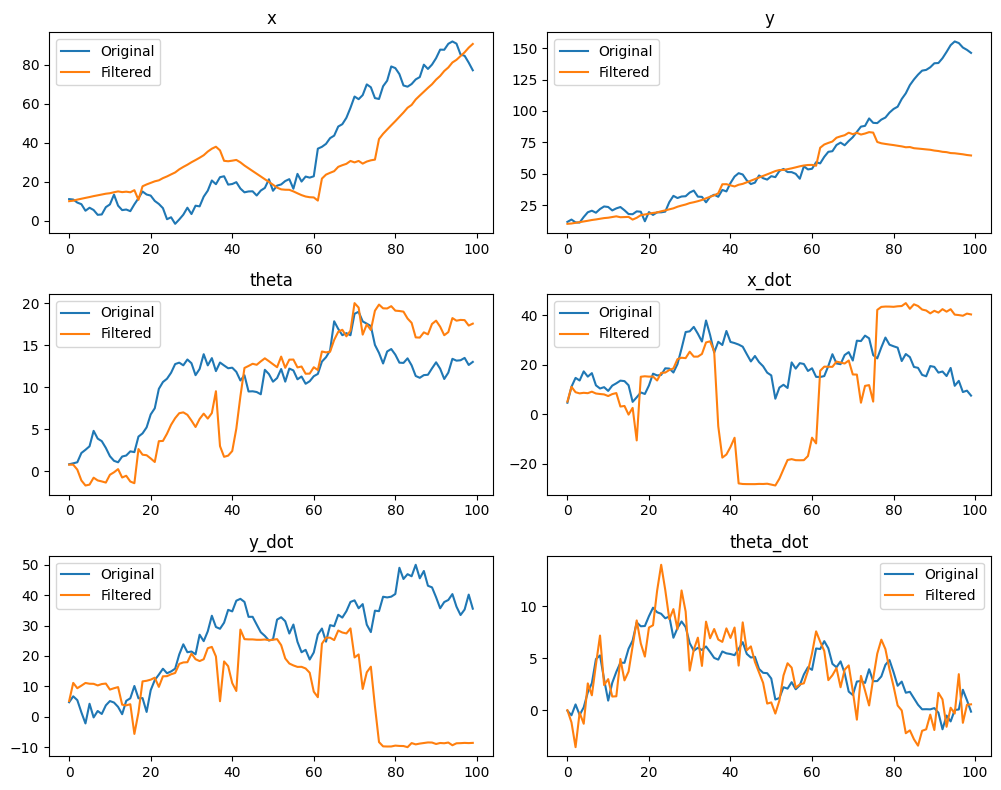

In [33]:
# Define the titles for each subplot
titles = ["x", "y", "theta", "x_dot", "y_dot", "theta_dot"]

# Create a figure and a set of subplots
fig, axes = plt.subplots(3, 2, figsize=(10, 8))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each row of z and z_filtered_array on its corresponding subplot
for i in range(6):
    axes[i].plot(z[i, :], label='Original')
    axes[i].plot(z_filtered_array[i, :], label='Filtered')
    axes[i].set_title(titles[i])
    axes[i].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [24]:
z_predicted_array = np.array(z_predicted)
z_predicted_array = z_predicted_array.T

In [25]:
# for i in range(1,N+1):
#     z_predicted_array[:,i] = generating_z_prediction(z_predicted_array[:,i], sigma_predicted[i]) 

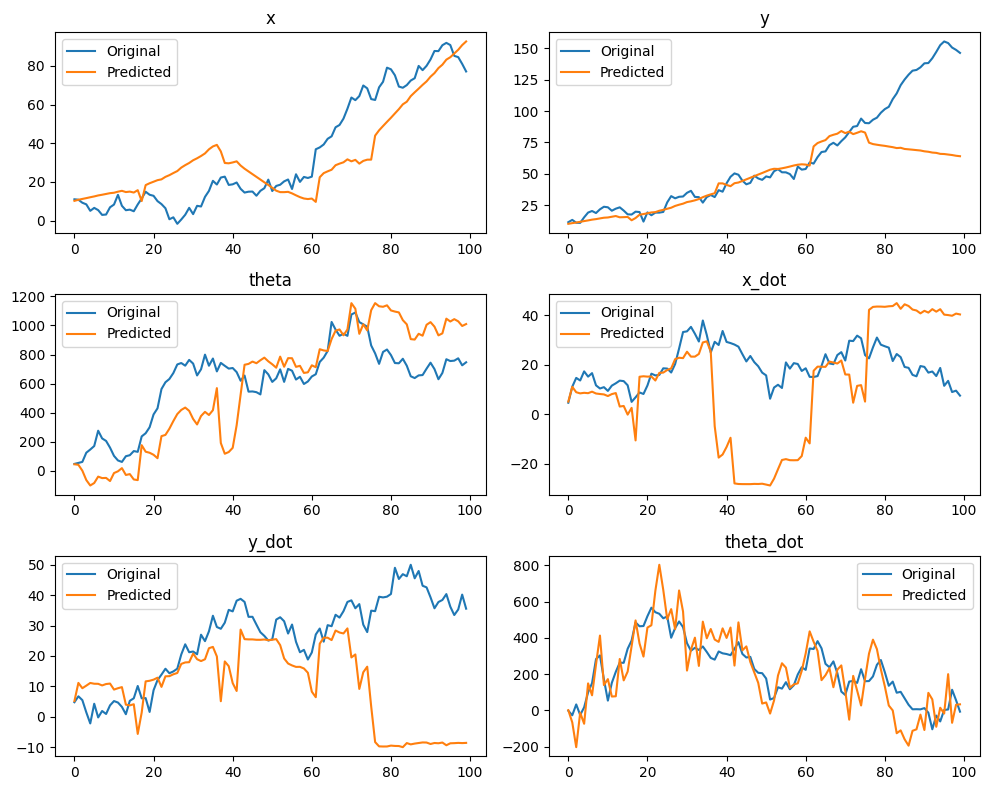

In [26]:
# Define the titles for each subplot
titles = ["x", "y", "theta", "x_dot", "y_dot", "theta_dot"]

# Create a figure and a set of subplots
fig, axes = plt.subplots(3, 2, figsize=(10, 8))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each row of z and z_filtered_array on its corresponding subplot
for i in range(6):
    gamma = 1
    if i == 2 or i == 5:
        gamma = 180/np.pi
    axes[i].plot(gamma*z[i, :], label='Original')
    axes[i].plot(gamma*z_predicted_array[i, 1:], label='Predicted')
    axes[i].set_title(titles[i])
    axes[i].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

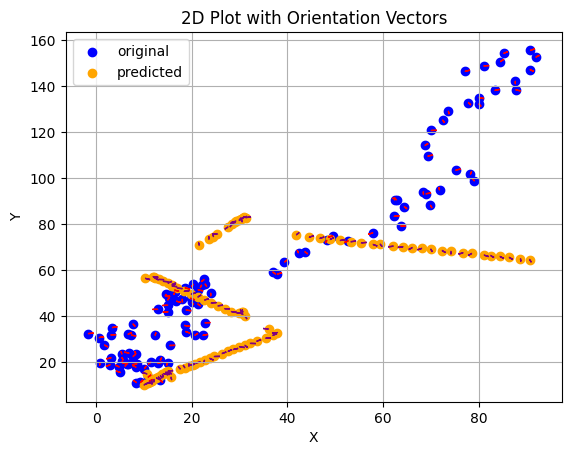

In [27]:
# Extract x, y, and theta from the data
x_coords = z[0,:]
y_coords = z[1,:]
thetas = z[2,:]

x_coords_filtered = z_filtered_array[0,:]
y_coords_filtered = z_filtered_array[1,:]
thetas_filtered = z_filtered_array[2,:]


# Plot the points
plt.figure()
plt.scatter(x_coords, y_coords, color='blue', label='original')
plt.scatter(x_coords_filtered, y_coords_filtered, color='orange', label='predicted')

# Draw the orientation vectors
for x, y, theta in zip(x_coords, y_coords, thetas):
    dx = np.cos(theta)
    dy = np.sin(theta)
    plt.arrow(x, y, dx, dy, head_width=0.1, head_length=0.1, fc='red', ec='red')

for x, y, theta in zip(x_coords_filtered, y_coords_filtered, thetas_filtered):
    dx = np.cos(theta)
    dy = np.sin(theta)
    plt.arrow(x, y, dx, dy, head_width=0.1, head_length=0.1, fc='purple', ec='purple')


# Set plot labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Plot with Orientation Vectors')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

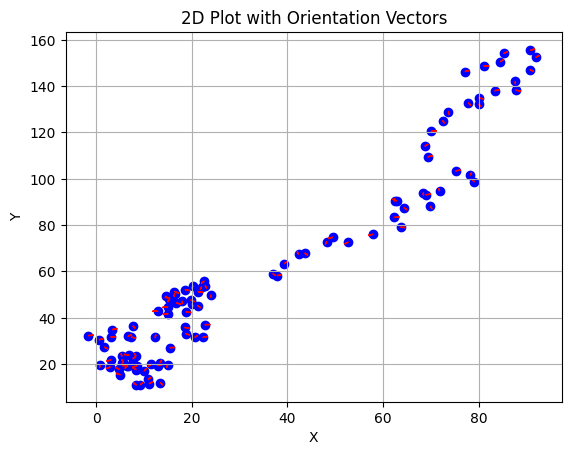

In [28]:
# Extract x, y, and theta from the data
x_coords = z[0,:]
y_coords = z[1,:]
thetas = z[2,:]

# Plot the points
plt.figure()
plt.scatter(x_coords, y_coords, color='blue')

# Draw the orientation vectors
for x, y, theta in zip(x_coords, y_coords, thetas):
    dx = np.cos(theta)
    dy = np.sin(theta)
    plt.arrow(x, y, dx, dy, head_width=0.1, head_length=0.1, fc='red', ec='red')

# Set plot labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Plot with Orientation Vectors')
plt.grid(True)

# Show the plot
plt.show()

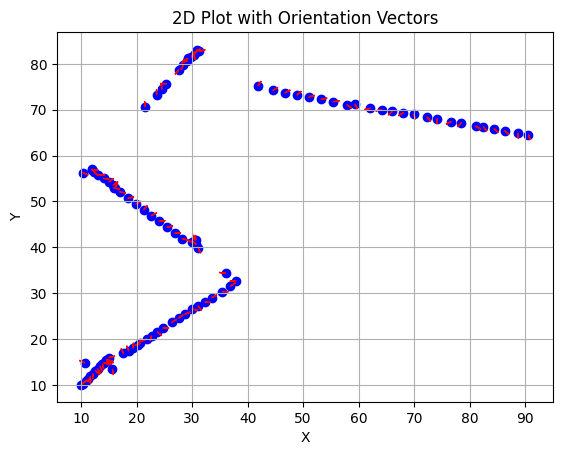

In [29]:
# Extract x, y, and theta from the data
x_coords = z_filtered_array[0,:]
y_coords = z_filtered_array[1,:]
thetas = z_filtered_array[2,:]

# Plot the points
plt.figure()
plt.scatter(x_coords, y_coords, color='blue')

# Draw the orientation vectors
for x, y, theta in zip(x_coords, y_coords, thetas):
    dx = np.cos(theta)
    dy = np.sin(theta)
    plt.arrow(x, y, dx, dy, head_width=0.1, head_length=0.1, fc='red', ec='red')

# Set plot labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Plot with Orientation Vectors')
plt.grid(True)

# Show the plot
plt.show()